In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
import _db_tools as db

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
#Data extraction
table_names = ['TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s', 'TOP_Passat_B9_limits_corrected_2023y_12m_13d_15h_47m_46s']
MEAS = retrieve_data("input.db", table_names[0])
LIMITS = retrieve_data("output.db", table_names[1])
MEAS

Table *TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s* retrieved succesfully.
Table *TOP_Passat_B9_limits_corrected_2023y_12m_13d_15h_47m_46s* retrieved succesfully.


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.3248,0.3261,0.3248,0.3252,0.3253,0.3249,0.3257,0.3256,0.3256,0.3244,...,0.3244,0.3246,0.3258,0.3241,0.3246,0.3253,0.3231,0.3244,0.3241,0.3249
1,0.3480,0.3489,0.3480,0.3491,0.3482,0.3485,0.3485,0.3497,0.3486,0.3476,...,0.3475,0.3492,0.3497,0.3481,0.3492,0.3497,0.3462,0.3479,0.3487,0.3483
2,0.3340,0.3332,0.3313,0.3316,0.3329,0.3312,0.3326,0.3314,0.3330,0.3329,...,0.3325,0.3309,0.3312,0.3319,0.3307,0.3305,0.3305,0.3325,0.3305,0.3325
3,0.3590,0.3586,0.3568,0.3573,0.3584,0.3570,0.3582,0.3573,0.3586,0.3585,...,0.3583,0.3572,0.3573,0.3579,0.3571,0.3568,0.3565,0.3583,0.3569,0.3584
4,0.3347,0.3385,0.3375,0.3383,0.3384,0.3383,0.3385,0.3384,0.3388,0.3387,...,0.3383,0.3382,0.3381,0.3383,0.3380,0.3384,0.3393,0.3384,0.3384,0.3390
5,0.3556,0.3659,0.3651,0.3658,0.3658,0.3657,0.3659,0.3659,0.3661,0.3661,...,0.3657,0.3658,0.3656,0.3657,0.3655,0.3658,0.3663,0.3658,0.3658,0.3663
6,0.3247,0.3247,0.3250,0.3251,0.3244,0.3252,0.3247,0.3243,0.3246,0.3239,...,0.3233,0.3237,0.3234,0.3236,0.3235,0.3237,0.3238,0.3238,0.3233,0.3233
7,0.3463,0.3472,0.3467,0.3468,0.3471,0.3469,0.3474,0.3472,0.3464,0.3469,...,0.3460,0.3462,0.3468,0.3458,0.3462,0.3471,0.3463,0.3464,0.3468,0.3468
8,0.3344,0.3318,0.3335,0.3336,0.3312,0.3334,0.3312,0.3315,0.3335,0.3310,...,0.3333,0.3333,0.3309,0.3333,0.3330,0.3311,0.3327,0.3332,0.3306,0.3309
9,0.3601,0.3585,0.3599,0.3599,0.3582,0.3599,0.3582,0.3585,0.3599,0.3582,...,0.3598,0.3599,0.3583,0.3598,0.3597,0.3583,0.3595,0.3599,0.3582,0.3582


In [ ]:
x = pd.concat([MEAS, LIMITS], axis=1)

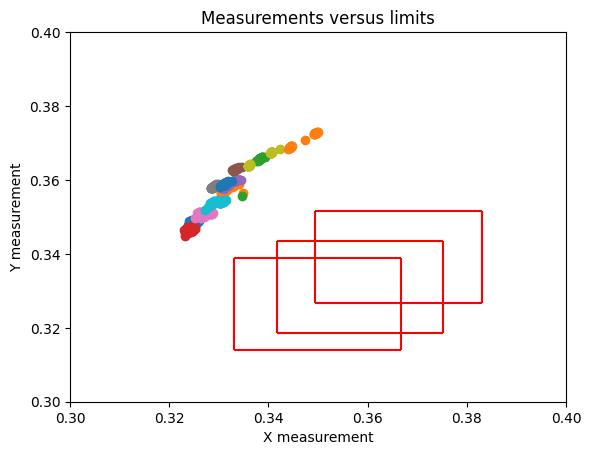

In [5]:
plot_simple_limits(MEAS, LIMITS, glob.nests_number, xrange=[0.3, 0.4], yrange=[0.3, 0.4], limit_filter=None)